In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from proto import *
from proto2 import *
from lab3_proto import *
from IPython.display import Audio,Image

In [3]:
from prondict import *
from states import *
example = np.load('lab3_example.npz')['example'].item()

Correctness Check

In [4]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
wordTrans = list(path2info(filename)[2])
phoneTrans = words2phones(wordTrans,prondict)
utteranceHMM = concatHMMs(phoneHMMs,phoneTrans,digit=''.join(wordTrans))

for k,v in example['utteranceHMM'].items():
    print("{} : {}".format(k,np.all(v == utteranceHMM[k])))

stateTrans = [phone +  '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
from sklearn.mixture import log_multivariate_normal_density
import warnings; warnings.simplefilter('ignore')

result = {}
result['obsloglik'] = log_multivariate_normal_density(lmfcc,utteranceHMM['means'],utteranceHMM['covars'],'diag')
result['viterbiLoglik'],result['viterbiStateIdTrans'] = viterbi(result['obsloglik'],np.log(utteranceHMM['startprob']),np.log(utteranceHMM['transmat'][:-1,:-1]))
result['viterbiStateTrans'] = [stateTrans[idx] for idx in result['viterbiStateIdTrans']]

print('obsloglik: ',np.allclose(result['obsloglik'],example['obsloglik']))
print('viterbiLoglik: ',np.allclose(result['viterbiLoglik'],example['viterbiLoglik']))
print('viterbiStateTrans: ',np.all(result['viterbiStateTrans'] == example['viterbiStateTrans']))

frames = frames2trans(result['viterbiStateTrans'],outfilename= ''.join(path2info(filename)[2:]) + '.lab')

covars : True
startprob : True
means : True
transmat : True
obsloglik:  True
viterbiLoglik:  True
viterbiStateTrans:  True


# Prepare the Data

Notice: I didn't use `sp` in forced alignment, the `concatHMMs` is the same as in lab2

## Forced Alignment

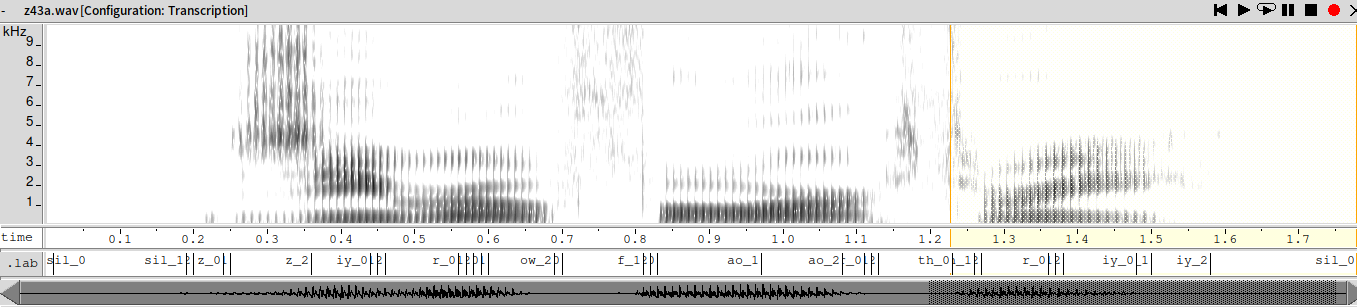

In [6]:
Image('figure/z43a_wosp.png')

When listening in digit separately according to the segment, it sounds like the alignment is correct.

### Observation
We can see the magnitude of `f` is high in high-freq. part (since it's unvoiced speech), and the magnitudes of others are high in low-freq. part.

## Feature Standardization

Basically, what we want to do is to **remove the channel effect**
On the frequency domain, such noise is **addictive**, so they can be removed using normalization.

1. normalize over whole training set, and use the corresponding mean and variance to standarisize testing and valid set <br>
 $\rightarrow$ Remove the **environment** effect (assume whole data are recordered under the same setting)
2. normalize over each speaker separately. <br>
 $\rightarrow$ Remove the **environment effect and difference between speaker**, less reliable than the first method but achive so-called **speaker adapation**
3. normalize each utterance <br>
 $\rightarrow$ since the time duration is short, the variance between the noise is large, not pretty reliable, especially for those short utterances

# Phoneme Recognition with DNN

In [ ]:
python train.py --feat_type dlmfcc --num_layer 4 --num_hid 256 --act_func relu --optimizer adam
python train.py --feat_type lmfcc --num_layer 4 --num_hid 256 --act_func relu --optimizer adam
python train.py --feat_type dmspec --num_layer 4 --num_hid 256 --act_func relu --optimizer adam
python train.py --feat_type mspec --num_layer 4 --num_hid 256 --act_func relu --optimizer adam
python train.py --feat_type dlmfcc --num_layer 1 --num_hid 1024 --act_func relu --optimizer adam
python train.py --feat_type dlmfcc --num_layer 4 --num_hid 256 --act_func relu --optimizer sgd
python train.py --feat_type dlmfcc --num_layer 4 --num_hid 256 --act_func sigmoid --optimizer adam

## Procedure of learning

|Model Idx| Feature Type |  # of layer | # of hidden | activation | optimizer | train accuracy|valid accuracy|
|--------|--------------|-------------|-------------|------------|-----------|---------------|--------------|
|    1   |dynamic lmfcc |        4    |256          |        relu|       adam|0.8014|0.7918|
|    2   |   lmfcc      |        4    |256          |        relu|       adam|0.6672|0.6368|
|    3   |dynamic mspec |        4    |256          |        relu|       adam|0.7909|0.7805|
|    4   |   mspec      |        4    |256          |        relu|       adam|0.6799|0.6527|
|    5   |dynamic lmfcc |        1    |1024         |        relu|       adam|0.6789|0.7034|
|    6   |dynamic lmfcc |        4    |256          |        relu|       sgd |0.8421|**0.8102**|
|    7   |dynamic lmfcc |        4    |256          |     sigmoid|       adam|0.8038|0.7841|

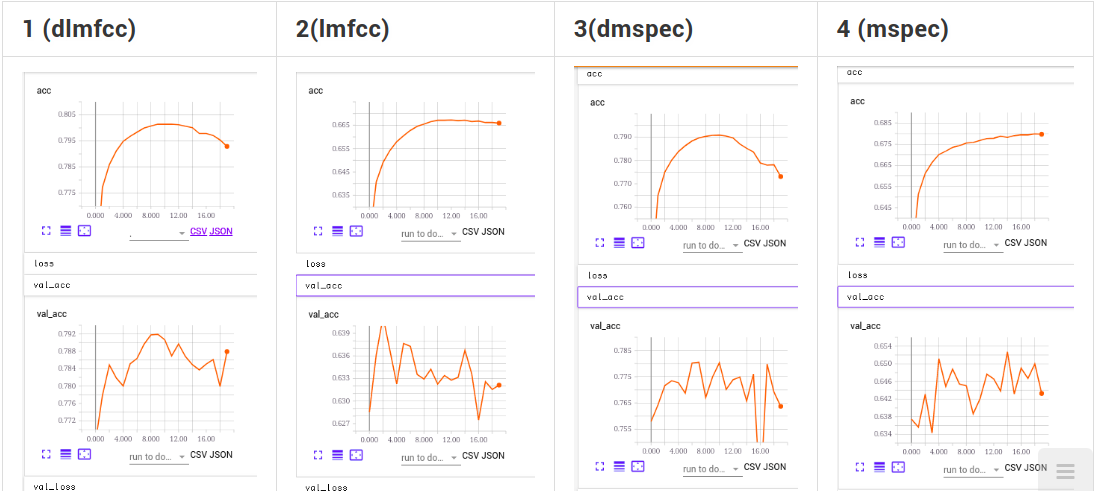

In [14]:
Image("figure/procedure1.png")

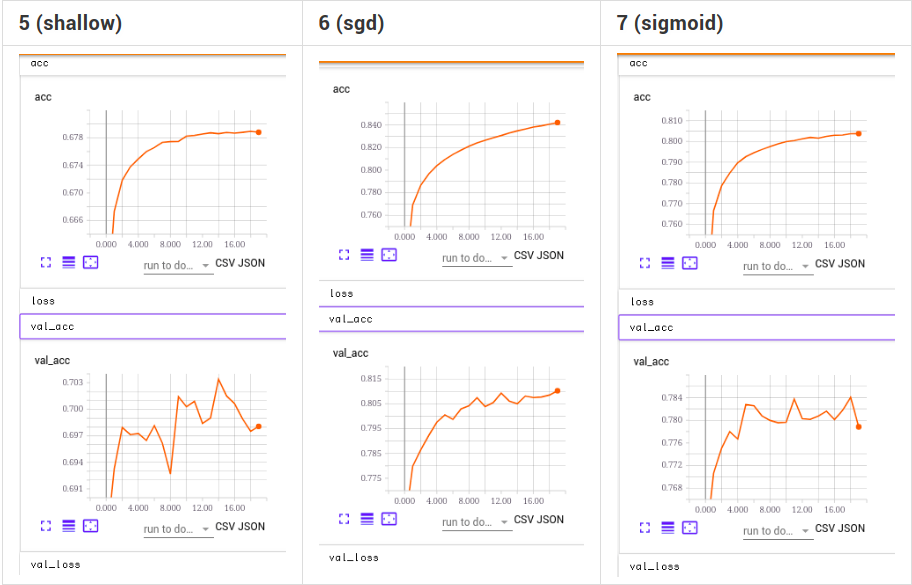

In [16]:
Image("figure/procedure2.png")

### Question and Observation

> What is the purpose of the validation data?

To help us select the model used for testing

> What can you say comparing the the evolution of the loss and accuracy of the model every epoch?

Take `accuracy` for example, in the beginning, valid and train accuracy will rise together.<br>
However after 5 poechs, the train accuracy became saturated (even dopped) and the valid accuracy begin oscillating.

> What is the influence of feature kind?

1. training speed (lmfcc is faster)
2. \# of parameter under same DNN (lmfcc is less), and the performance(lmfcc is better)
Since mspec also catches some undesired excitation into the model, so the accuracy is a little bit worse/

> What is the influence of size of input context window?

Take **dynamic feature** into consider, to catch the tiny transition between states. We can see the huge improvement of adding this (nearly **10%**)

> What is the influence of \# of layers and \# of hidden units?

Shallow and fat network sometimes cannot model properly (like the exp. showed). But it depends.

> What is the influence of optimizer (learning rate strategy)?

Decide the covergence speed and stability of training procedure.<br>
In this case, `sgd` is more stable than `adam` and the final result is better.

According to the validation accuracy, I choose **model5:dlmfcc_4layer_256hidden_relu_sgd_epoch20** for further detailed evaluation.

## Evaluation

* FrameByFrame Accuracy on state level: 0.781049
* FrameByFrame Accuracy on phoneme level: 0.862925

The following is the average over **8700** utterances
* PER on state level: 51.01033
* PER on phoneme level: 89.027602

> Question: Why PER higher on phoneme level but framebyframe lower on phoneme level?

Consider:
```
pred = ['sil_0','sil_1','sil_2','z_1','sil_2']
label = ['sil_0','sil_1','sil_1','sil_2','sil_2']
```
```
FrameByFrame Acc on state level: 0.6
FrameByFrame Acc on phoneme level: 0.8
PER on state level: (2/3)\*100 = 66.6
PER on state level: (2/1)\*100 = 200
```

tidigits/disc_4.2.1/tidigits/test/man/pr/6821a.wav


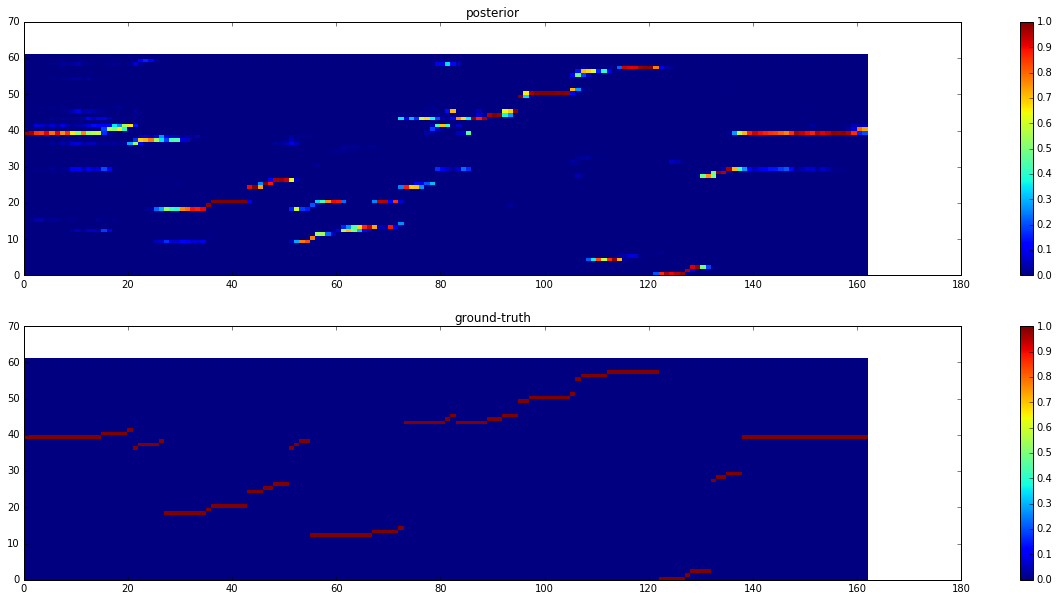

In [47]:
plt.figure(figsize=(21, 10))

posterior = np.load('posterior.npz')['posterior'].T
plt.subplot(2,1,1)
plt.title("posterior")
pcolormesh(posterior)
colorbar()

test_utt = np.load('data/test_data.npz')['data'][0]
targets = np.load('data/test_y.npz')['y'][:162]
from keras.utils import np_utils
plt.subplot(2,1,2)
plt.title("ground-truth")
pcolormesh(np_utils.to_categorical(targets,61).T)
colorbar()

print(test_utt['filename'])

Roughly the same! The following is the statistics.

* F2F Accuracy on state level: 0.759259
* F2F Accuracy on phoneme level: 0.808642
* PER on state level: 48.648649
* PER on phoneme level: 150.000000


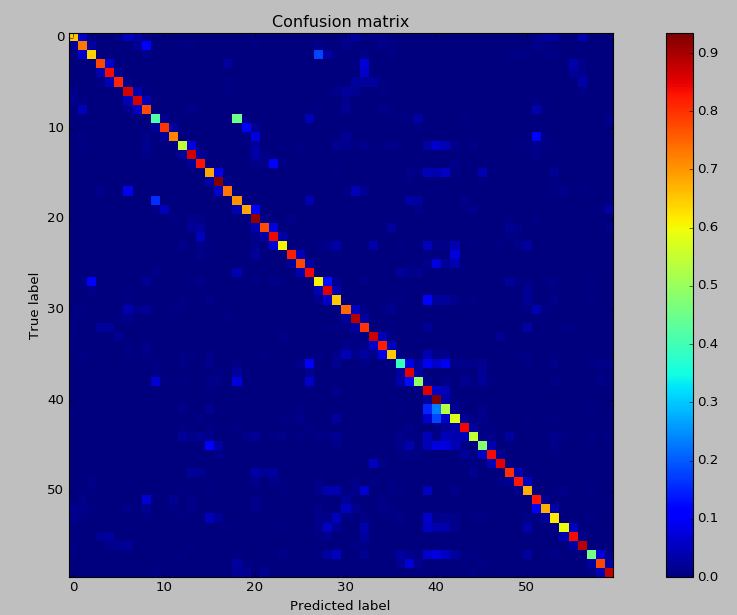

In [60]:
Image('figure/conf_mat_state.png',width=500,height=500)

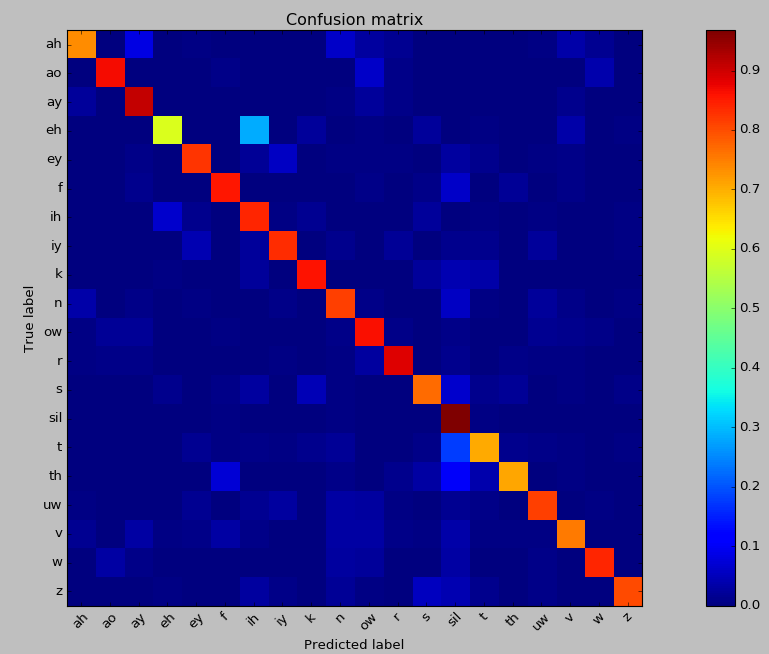

In [59]:
Image('figure/conf_mat_phoneme.png',width=600,height=600)

* `eh`, `ih` is confused to the classifier
* discriminative power between `sil` and other phonemes are good
* unvoiced phoneme (like `f`, `s`, `t`, `th`) are prone to be recognized to `sil` or each other